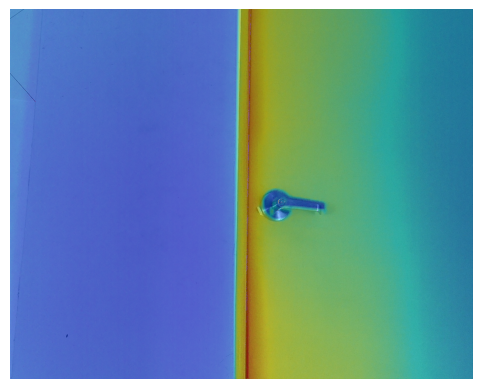

In [1]:
#Prueba por Transformada Discreta de Wavelet (DWT)

import numpy as np
import cv2
from skimage import io, color, exposure
import matplotlib.pyplot as plt
import numpy as np
import pywt
from PIL import Image
import os

# método de fusión de imágenes basado en la transformada wavelet bidimensional

def imgfusion(Im1, Im2, ftype, wtype):
    # Se realiza la descomposición wavelet bidimensional de la primera imagen Im1 utilizando la función dwt2
    # Convertir imágenes a float y realizar la descomposición de wavelet de nivel 1
    coeffs1 = pywt.dwt2(Im1.astype(float), wtype, 'periodization')
    coeffs2 = pywt.dwt2(Im2.astype(float), wtype, 'periodization')
    
    # Extraer las sub-bandas de aproximación y detalle
    # cA1 representa la aproximación, mientras que (cH1, cV1, cD1) son las 
    # sub-bandas de detalles en las direcciones horizontal, vertical y diagonal, respectivamente.
    cA1, (cH1, cV1, cD1) = coeffs1
    cA2, (cH2, cV2, cD2) = coeffs2

    
    # Preparar matrices de coeficientes para la imagen resultante
    cA = np.zeros_like(cA1)
    cH = np.zeros_like(cH1)
    cV = np.zeros_like(cV1)
    cD = np.zeros_like(cD1)
    \
    #Se inicia un bucle que recorre cada elemento de las sub-bandas para realizar la fusión según el tipo especificado en ftype.
    # Procesar según el tipo de fusión especificado
    for i in range(cA1.shape[0]):
        for k in range(cA1.shape[1]):
            if ftype == 'MeanMean':
                cA[i, k] = np.mean([cA1[i, k], cA2[i, k]])
                cH[i, k] = np.mean([cH1[i, k], cH2[i, k]])
                cV[i, k] = np.mean([cV1[i, k], cV2[i, k]])
                cD[i, k] = np.mean([cD1[i, k], cD2[i, k]])
            # Repetir estructura similar para otros casos como 'MeanMax', 'MaxMean', etc.
        
    # Usar todas las combinaciones de fusión como se define en MATLAB
            elif ftype == 'MeanMax':
                cA[i, k] = np.mean([cA1[i, k], cA2[i, k]])
                cH[i, k] = np.max([cH1[i, k], cH2[i, k]])
                cV[i, k] = np.max([cV1[i, k], cV2[i, k]])
                cD[i, k] = np.max([cD1[i, k], cD2[i, k]])
            # Continuar con otras condiciones...

    # Reconstruir la imagen fusionada usando los coeficientes fusionados
    #Después de realizar la fusión de coeficientes, se utiliza pywt.idwt2 para 
    #reconstruir la imagen fusionada a partir de los coeficientes fusionados.
    outimage = pywt.idwt2((cA, (cH, cV, cD)), wtype, 'periodization')
    return outimage


# -----------------------------------------------------------------------------------
fusiontype = 'MeanMax'
wavetype = 'coif5'

# Cargar la imagen recortada anterior J
img1 = np.array(Image.open('imagen_recortada.jpg'))

# Cargar la imagen térmica
img2 = np.array(Image.open('imagen_termica4.JPG'))

# Asegurar que img2 tenga el mismo tamaño que img1
if img1.shape != img2.shape:
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Obtener las dimensiones de la imagen recortada
row, col, _ = img1.shape

# Fusionar las imágenes canal por canal utilizando la función imgfusion
fusedimageR = imgfusion(img1[:, :, 0], img2[:, :, 0], fusiontype, wavetype)
fusedimageG = imgfusion(img1[:, :, 1], img2[:, :, 1], fusiontype, wavetype)
fusedimageB = imgfusion(img1[:, :, 2], img2[:, :, 2], fusiontype, wavetype)

# Combinar los canales fusionados en una sola imagen
fusedimage = np.uint8(np.stack([fusedimageR, fusedimageG, fusedimageB], axis=-1))


# Guardar y mostrar la imagen fusionada
# Define el directorio donde se guardará la imagen
directory = 'DWT'

# Crea el directorio si no existe
if not os.path.exists(directory):
    os.makedirs(directory)

# Define la ruta completa del archivo
file_path = os.path.join(directory, 'FUSION_DWT.jpg')

# Convierte el array de NumPy en una imagen y guárdala con la máxima calidad
Image.fromarray(fusedimage).save(file_path, quality=100)

# Muestra la imagen usando matplotlib
plt.imshow(fusedimage)
plt.axis('off')  # Elimina los ejes para una visualización más limpia
plt.show()


# Mostrar las imágenes originales y la imagen fusionada
#plt.figure(figsize=(12, 6))

#plt.subplot(1, 3, 1)
#plt.imshow(img1)
#plt.title('Imagen RGB')
#plt.axis('off')

#plt.subplot(1, 3, 2)
#plt.imshow(img2)
#plt.title('Imagen Térmica')
#plt.axis('off')

#plt.subplot(1, 3, 3)
#plt.imshow(fusedimage)
#plt.title('Imagen Fusionada (DWT)')
#plt.axis('off')



#plt.show()








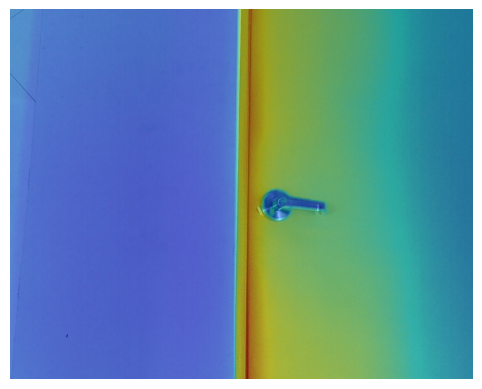

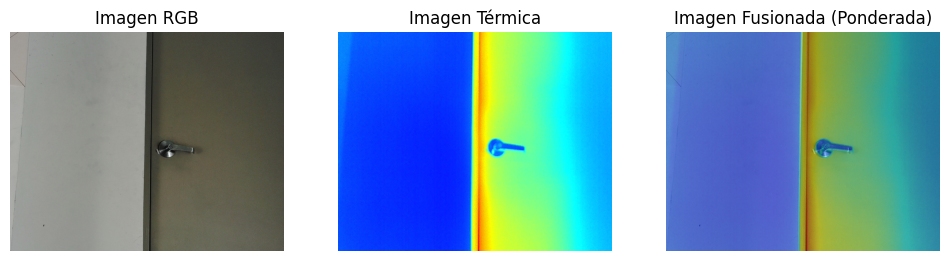

In [83]:
# METODO Fusión Basada en Ponderación

import numpy as np
from PIL import Image

#weight_rgb: el peso asignado a la imagen RGB en la fusión.
#weight_thermal: el peso asignado a la imagen térmica en la fusión.
#output_size: tamaño de salida opcional para las imágenes redimensionadas.

def weighted_fusion(img_rgb, img_thermal, weight_rgb, weight_thermal, output_size=None):
    # Convertir imágenes a arrays de numpy
    img_rgb = np.array(img_rgb)
    img_thermal = np.array(img_thermal)
    
    # Redimensionar imágenes si es necesario
    if output_size is not None:
        img_rgb = np.array(Image.fromarray(img_rgb).resize(output_size, Image.Resampling.LANCZOS))
        img_thermal = np.array(Image.fromarray(img_thermal).resize(output_size, Image.Resampling.LANCZOS))
    
    # Asegurar que img_thermal tenga 3 canales si es necesario
    #Si img_thermal es una imagen de un solo canal (en escala de grises), esta línea la convierte en una imagen de 
    #tres canales duplicando el canal existente en los tres canales RGB necesarios para la fusión.
    if len(img_thermal.shape) == 2:
        img_thermal = np.stack((img_thermal,)*3, axis=-1)
    
    # Normalizar las imágenes
    #Estas líneas convierten los valores de píxeles de las imágenes de enteros (de 0 a 255) a 
    #flotantes (de 0.0 a 1.0). Esto es necesario para la fusión ponderada y mantiene la precisión 
    img_rgb = img_rgb.astype(float) / 255
    img_thermal = img_thermal.astype(float) / 255
    
    # Aplicar la fusión ponderada
    #La primera línea realiza la fusión ponderada
    fused_image = (img_rgb * weight_rgb + img_thermal * weight_thermal) / (weight_rgb + weight_thermal)
    #Cada pixel de la imagen resultante es el promedio ponderado de los píxeles correspondientes en las imágenes img_rgb y img_thermal


    #La segunda línea escala los valores de nuevo al rango 0-255 y los convierte a enteros de 8 bits.
    #La función np.clip asegura que todos los valores permanezcan dentro del rango válido para imágenes
    fused_image = np.clip(fused_image * 255, 0, 255).astype(np.uint8)  # Convertir de vuelta a uint8
    

    #retorna el resultado de la fusión,
    return fused_image


#-------------------------------------------------------------------------------------------


# Cargar las imágenes
rgb_image = np.array(Image.open('imagen_recortada.jpg'))
thermal_image = np.array(Image.open('imagen_termica4.jpg'))

# Ajustar el tamaño de las imágenes si es necesario
thermal_image = cv2.resize(thermal_image, (rgb_image.shape[1], rgb_image.shape[0]))

# Definir los pesos para la fusión
weight_rgb = 0.5
weight_thermal = 0.5

# Fusionar las imágenes utilizando la función weighted_fusion
fused_image = weighted_fusion(rgb_image, thermal_image, weight_rgb, weight_thermal)

# Guardar y mostrar la imagen fusionada
# Define el directorio donde se guardará la imagen
directory = 'Ponderada'

# Crea el directorio si no existe
if not os.path.exists(directory):
    os.makedirs(directory)

# Define la ruta completa del archivo
file_path = os.path.join(directory, 'FUSION_Ponderada.jpg')

# Convierte el array de NumPy en una imagen y guárdala con la máxima calidad
Image.fromarray(fused_image).save(file_path, quality=100)

# Muestra la imagen usando matplotlib
plt.imshow(fused_image)
plt.axis('off')  # Elimina los ejes para una visualización más limpia
plt.show()

# Mostrar las imágenes originales y la imagen fusionada
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title('Imagen RGB')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(thermal_image)
plt.title('Imagen Térmica')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(fused_image)
plt.title('Imagen Fusionada (Ponderada)')
plt.axis('off')



plt.show()





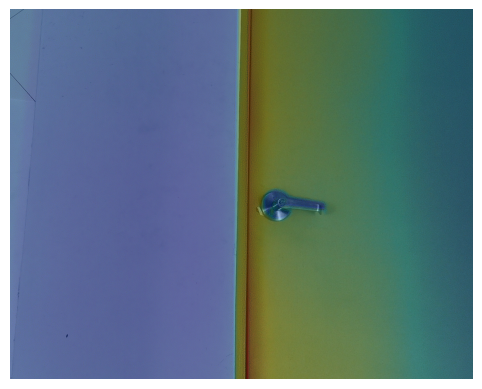

In [2]:

# METODO fusión basada en la transformada de Laplace-Gauss


import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def log_transform(image, sigma=1.0):
    # Aplicar desenfoque gaussiano
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    # Aplicar la transformada Laplace
    log_image = cv2.Laplacian(blurred, cv2.CV_64F)
    return log_image

def fuse_images_log_color(rgb_image, thermal_image, sigma=1.0):
    # Convertir la imagen térmica a escala de grises
    thermal_gray = cv2.cvtColor(thermal_image, cv2.COLOR_RGB2GRAY)
    
    # Aplicar la transformada LoG a la imagen térmica en escala de grises
    log_thermal = log_transform(thermal_gray, sigma)
    
    # Normalizar la transformada LoG al rango [0, 1]
    log_thermal_normalized = cv2.normalize(log_thermal, None, 0, 1, cv2.NORM_MINMAX)
    
    # Redimensionar la imagen térmica a las dimensiones de la imagen RGB si es necesario
    if rgb_image.shape[:2] != thermal_image.shape[:2]:
        thermal_image = cv2.resize(thermal_image, (rgb_image.shape[1], rgb_image.shape[0]))
    
    # Fusionar las imágenes utilizando una máscara basada en la transformada LoG
    fused_image = cv2.addWeighted(rgb_image.astype(np.float64), 1.0, 
                                  (thermal_image * log_thermal_normalized[:,:,np.newaxis]).astype(np.float64), 1.0, 0)
    
    # Escalar la imagen fusionada al rango de 0 a 255 y convertir a uint8
    fused_image = cv2.normalize(fused_image, None, 0, 255, cv2.NORM_MINMAX)
    fused_image = np.uint8(fused_image)
    
    return fused_image

# Cargar las imágenes
rgb_image = np.array(Image.open('imagen_recortada.jpg'))
thermal_image = np.array(Image.open('imagen_termica4.jpg'))


# Ajustar el tamaño de las imágenes si es necesario
# Asegurar que las imágenes tengan el mismo tamaño
thermal_image = cv2.resize(thermal_image, (rgb_image.shape[1], rgb_image.shape[0]))
# (asegúrate de que tengan las mismas dimensiones)


# Fusionar las imágenes utilizando la transformada LoG y conservación del color
fused_image = fuse_images_log_color(rgb_image, thermal_image)


# Guardar y mostrar la imagen fusionada
# Define el directorio donde se guardará la imagen
directory = 'LoG'

# Crea el directorio si no existe
if not os.path.exists(directory):
    os.makedirs(directory)

# Define la ruta completa del archivo
file_path = os.path.join(directory, 'FUSION_Log_Color.jpg')

# Convierte el array de NumPy en una imagen y guárdala con la máxima calidad
Image.fromarray(fused_image).save(file_path, quality=100)

# Muestra la imagen usando matplotlib
plt.imshow(fused_image)
plt.axis('off')  # Elimina los ejes para una visualización más limpia
plt.show()




# Mostrar las imágenes originales y la imagen fusionada
#plt.figure(figsize=(12, 6))

#plt.subplot(1, 3, 1)
#plt.imshow(rgb_image)
#plt.title('Imagen RGB')
#plt.axis('off')

#plt.subplot(1, 3, 2)
#plt.imshow(thermal_image)
#plt.title('Imagen Térmica')
#plt.axis('off')

#plt.subplot(1, 3, 3)
#plt.imshow(fused_image)
#plt.title('Imagen Fusionada (LoG con Color)')
#plt.axis('off')

#plt.show()



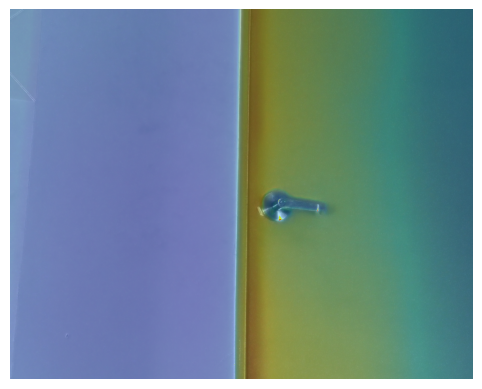

In [3]:
# Metodo Fusión basada en pirámide gaussiana:



import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

#Crea una pirámide gaussiana de la imagen, reduciendo la resolución de la imagen en cada nivel.
def gaussian_pyramid(image, levels):
    pyramid = [image]
    for _ in range(levels - 1):
        image = cv2.pyrDown(image) #Reduce la imagen a la mitad de su tamaño original usando un filtro gaussiano
        pyramid.append(image) #Añade la imagen reducida a la pirámide.
    return pyramid



#Crea una pirámide laplaciana a partir de una pirámide gaussiana.
def laplacian_pyramid(image, levels):
    gaussian = gaussian_pyramid(image, levels)
    pyramid = [gaussian[-1]] #Inicia la pirámide laplaciana con el nivel más bajo de la pirámide gaussiana.
    for i in range(levels - 1, 0, -1):
        expanded = cv2.pyrUp(gaussian[i])
        if expanded.shape[:2] != gaussian[i - 1].shape[:2]:
            expanded = cv2.resize(expanded, (gaussian[i - 1].shape[1], gaussian[i - 1].shape[0]))
        laplacian = cv2.subtract(gaussian[i - 1], expanded)
        pyramid.append(laplacian) #Añade la imagen laplaciana a la pirámide.
    return pyramid #Devuelve la pirámide laplaciana completa.



#Reconstruye la imagen original a partir de una pirámide laplaciana.
def reconstruct_from_pyramid(pyramid):
    image = pyramid[0] #Inicia con el nivel más bajo de la pirámide.
    for level in pyramid[1:]: # Itera sobre los niveles restantes de la pirámide.
        image = cv2.pyrUp(image)
        if image.shape[:2] != level.shape[:2]:
            image = cv2.resize(image, (level.shape[1], level.shape[0]))
        image = cv2.add(image, level) #Añade el nivel actual a la imagen expandida
    return image #Devuelve la imagen reconstruida.



#Fusiona dos imágenes utilizando pirámides laplacianas y gaussianas.
def gaussian_pyramid_fusion(image1, image2, levels):
   
    # Generate Laplacian pyramids for both images
    laplacian1 = laplacian_pyramid(image1, levels)
    laplacian2 = laplacian_pyramid(image2, levels)
    
    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
    
    # Generate Gaussian pyramid for a mask (average of two images)
    mask = np.ones_like(image1)
    mask1 = gaussian_pyramid(mask, levels)
    mask2 = gaussian_pyramid(mask, levels)
    
    # Resize Laplacian pyramids and masks to match image dimensions
    #Ajusta el tamaño de los niveles de las pirámides y máscaras si es necesario.
    for i in range(len(laplacian1)):
        if laplacian1[i].shape != image1.shape:
            laplacian1[i] = cv2.resize(laplacian1[i], (image1.shape[1], image1.shape[0]))
        if laplacian2[i].shape != image2.shape:
            laplacian2[i] = cv2.resize(laplacian2[i], (image2.shape[1], image2.shape[0]))
        if mask1[i].shape != image1.shape:
            mask1[i] = cv2.resize(mask1[i], (image1.shape[1], image1.shape[0]))
        if mask2[i].shape != image2.shape:
            mask2[i] = cv2.resize(mask2[i], (image2.shape[1], image2.shape[0]))
    
    # Combine the Laplacian pyramids of the two images weighted by the mask

    fused_pyramid = [] #nicia una lista para la pirámide fusionada.
    #Fusiona los niveles de las pirámides utilizando una ponderación
    for l1, l2, m1, m2 in zip(laplacian1, laplacian2, mask1, mask2): #Fusiona los niveles con una ponderación de 0.7 y 0.3.
        # Blending the RGB colors of the two images
        fused_rgb = 0.7 * m1 * l1 + 0.3 * m2 * l2
        fused_pyramid.append(fused_rgb)
    


    # Reconstruct the fused image from the fused Laplacian pyramid
    #Reconstruye la imagen fusionada a partir de la pirámide fusionada.
    fused_image = reconstruct_from_pyramid(fused_pyramid)
    
    return fused_image

# Load the images
image1 = np.array(Image.open('imagen_recortada.jpg'))
image2 = np.array(Image.open('imagen_termica4.jpg'))

# Number of pyramid levels
#Para muchas aplicaciones prácticas, cuatro niveles son suficientes para capturar las variaciones
#importantes en la imagen sin ser excesivamente costoso en términos de recursos
#En muchos estudios y aplicaciones prácticas, se ha encontrado que 3 a 5 niveles de la pirámide son 
#adecuados para una buena calidad de fusión
levels = 4

# Perform Gaussian pyramid fusion
fused_image = gaussian_pyramid_fusion(image1, image2, levels)

fused_image = fused_image.astype(np.uint8)

# Display the fused image

# Guardar y mostrar la imagen fusionada
# Define el directorio donde se guardará la imagen
directory = 'Piramide_gaussiana'

# Crea el directorio si no existe
if not os.path.exists(directory):
    os.makedirs(directory)

# Define la ruta completa del archivo
file_path = os.path.join(directory, 'FUSION_piramide_gaussiana.jpg')

# Convierte el array de NumPy en una imagen y guárdala con la máxima calidad
Image.fromarray(fused_image).save(file_path, quality=100)

# Muestra la imagen usando matplotlib
plt.imshow(fused_image)
plt.axis('off')  # Elimina los ejes para una visualización más limpia
plt.show()


# Mostrar las imágenes con Matplotlib
#plt.figure(figsize=(12, 6))

#plt.subplot(1, 3, 1)
#plt.imshow(image1)
#plt.title('Imagen 1')

#plt.subplot(1, 3, 2)
#plt.imshow(image2)
#plt.title('Imagen 2')

#plt.subplot(1, 3, 3)
#Image.fromarray(fused_image).save('FUSION_piramide_gaussiana.jpg', quality=100)
#plt.imshow(fused_image)

#plt.show()

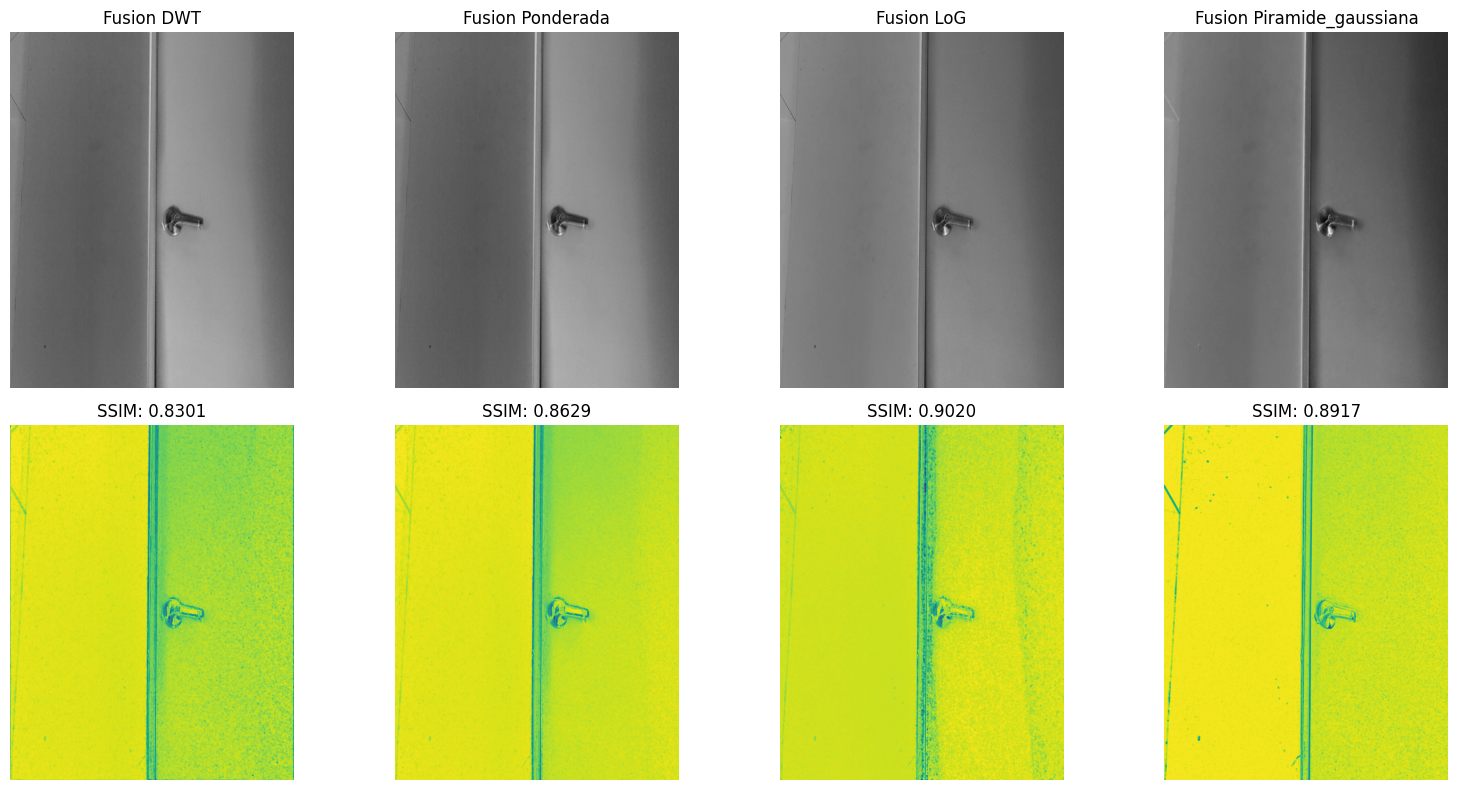

In [74]:
#ANALISIS DE LAS FUSIONES:


# METODO PARA COMPARAR LA FUSION

# 1. METODO SSIM


import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Función para cargar y redimensionar imágenes
def load_and_resize_image_from_directory(directory_path, image_name, target_size):
    image_path = os.path.join(directory_path, image_name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, target_size[::-1])  # Revertir las dimensiones de target_size
    return image_resized

# Rutas de los directorios de las imágenes fusionadas (modifica según sea necesario)
fusion_directories = ['DWT', 'Ponderada', 'LoG', 'Piramide_gaussiana']

# Nombres de las imágenes fusionadas
fusion_image_names = ['FUSION_DWT.jpg', 'FUSION_Ponderada.jpg', 'FUSION_Log_Color.jpg', 'FUSION_Piramide_gaussiana.jpg']

# Ruta de la imagen RGB (modifica según sea necesario)
image_rgb_path = 'imagen_recortada.jpg'

# Dimensiones objetivo
target_size = (1759, 1406)

# Cargar y redimensionar la imagen RGB
image_rgb = load_and_resize_image_from_directory('', image_rgb_path, target_size)

# Calcular y mostrar el SSIM para cada imagen fusionada
plt.figure(figsize=(16, 8))

for i, (method, directory_name) in enumerate(zip(fusion_directories, fusion_image_names), 1):
    # Cargar y redimensionar la imagen fusionada
    image_fusionada = load_and_resize_image_from_directory(method, directory_name, target_size)
    
    # Calcular el SSIM entre la imagen fusionada y la imagen RGB
    #Calcula el índice de similitud estructural (SSIM) entre la imagen fusionada y la imagen RGB.
    # ssim devuelve el índice SSIM y el mapa de similitud estructural (ssim_image).
    ssim_index, ssim_image = ssim(image_fusionada, image_rgb, full=True)

    # Mostrar la imagen fusionada y el mapa de similitud estructural
    plt.subplot(2, 4, i)
    plt.imshow(image_fusionada, cmap='gray')
    plt.title(f'Fusion {method}')
    plt.axis('off')

    plt.subplot(2, 4, i + len(fusion_directories))
    plt.imshow(ssim_image, cmap='viridis')
    plt.title(f'SSIM: {ssim_index:.4f}')
    plt.axis('off')

plt.tight_layout()
plt.show()


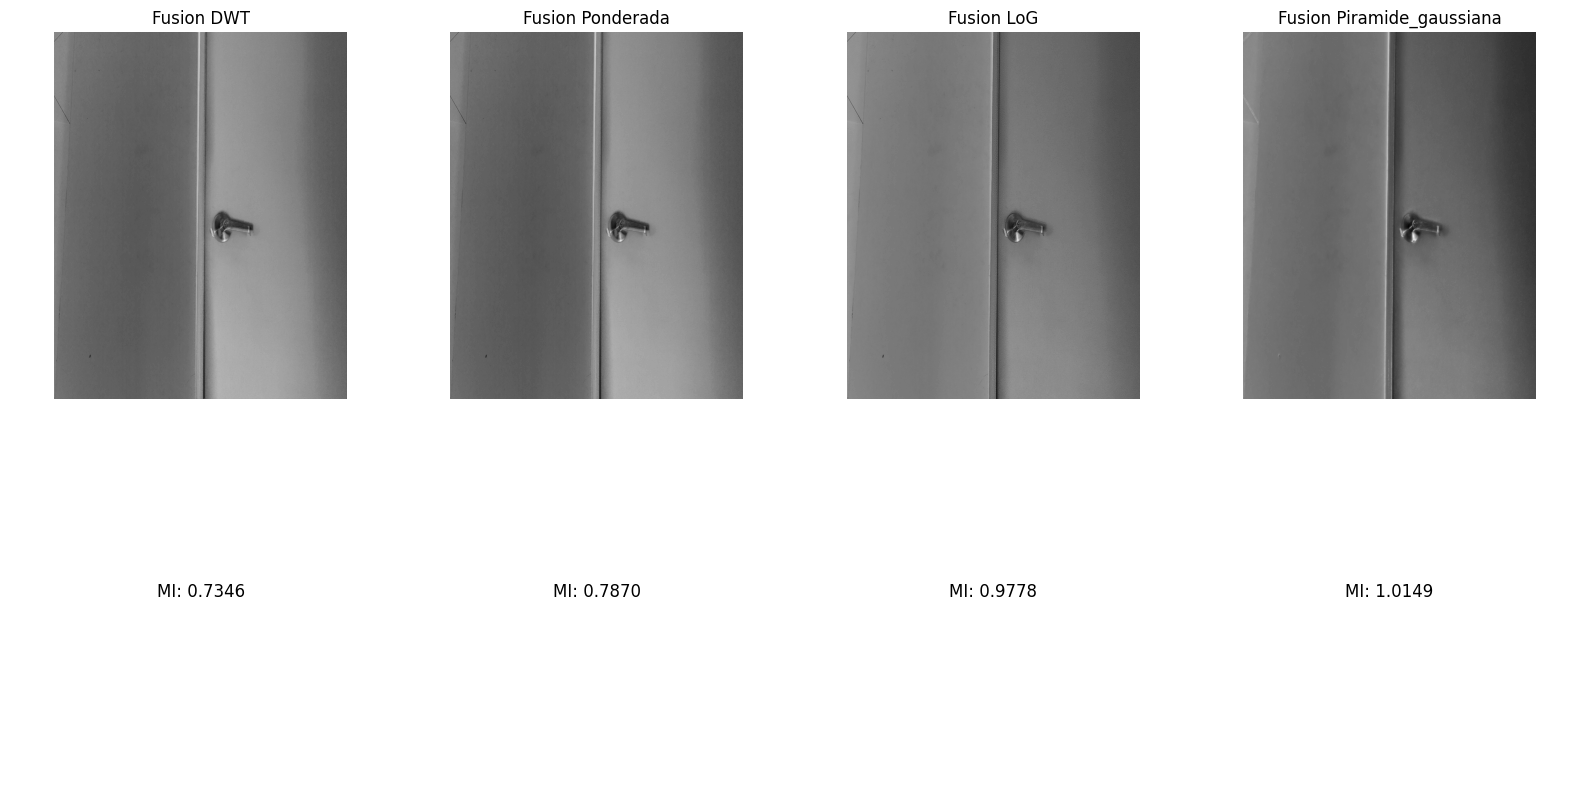

In [75]:


# 2. METODO IM, (ESTA MAL REVISAR YA QUE MI tiene que ser menor a 1)
# (PREGUNTAR PROFESOR)


import os
import cv2
import numpy as np
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt

# Función para cargar y redimensionar imágenes
def load_and_resize_image_from_directory(directory_path, image_name, target_size):
    #Construye la ruta completa de la imagen concatenando el directorio y el nombre del archivo.
    image_path = os.path.join(directory_path, image_name)
    #Carga la imagen en modo de escala de grises.
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    #Redimensiona la imagen a target_size. Las dimensiones se invierten debido a cómo OpenCV maneja las dimensiones
    image_resized = cv2.resize(image, target_size[::-1])  # Revertir las dimensiones de target_size
    return image_resized



# Directorios de las imágenes fusionadas y nombres de las imágenes
#Lista de nombres de directorios que contienen las imágenes fusionadas.
fusion_directories = ['DWT', 'Ponderada', 'LoG', 'Piramide_gaussiana']
#Lista de nombres de las imágenes fusionadas.
fusion_image_names = ['FUSION_DWT.jpg', 'FUSION_Ponderada.jpg', 'FUSION_Log_Color.jpg', 'FUSION_Piramide_gaussiana.jpg']




# Ruta de la imagen RGB y dimensiones objetivo
image_rgb_path = 'imagen_recortada.jpg'
target_size = (1759, 1406)



# Cargar y redimensionar la imagen RGB
#Carga y redimensiona la imagen RGB original utilizando la función definida anteriormente.
image_rgb = load_and_resize_image_from_directory('', image_rgb_path, target_size)


# Crear una figura para mostrar las imágenes
plt.figure(figsize=(16, 8))
# Iterar sobre las imágenes fusionadas
for i, (method, directory_name) in enumerate(zip(fusion_directories, fusion_image_names), 1):
    # Cargar y redimensionar la imagen fusionada
    image_fusionada = load_and_resize_image_from_directory(method, directory_name, target_size)
    
    # Calcular la Información Mutua (MI) entre la imagen fusionada y la imagen RGB
    mi_score = mutual_info_score(image_fusionada.ravel(), image_rgb.ravel())
    
    # Mostrar la imagen fusionada y el valor de la Información Mutua (MI)
    plt.subplot(2, 4, i)
    plt.imshow(image_fusionada, cmap='gray')
    plt.title(f'Fusion {method}')
    plt.axis('off')

    plt.subplot(2, 4, i + len(fusion_directories))
    plt.text(0.5, 0.5, f'MI: {mi_score:.4f}', fontsize=12, ha='center')
    plt.axis('off')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()




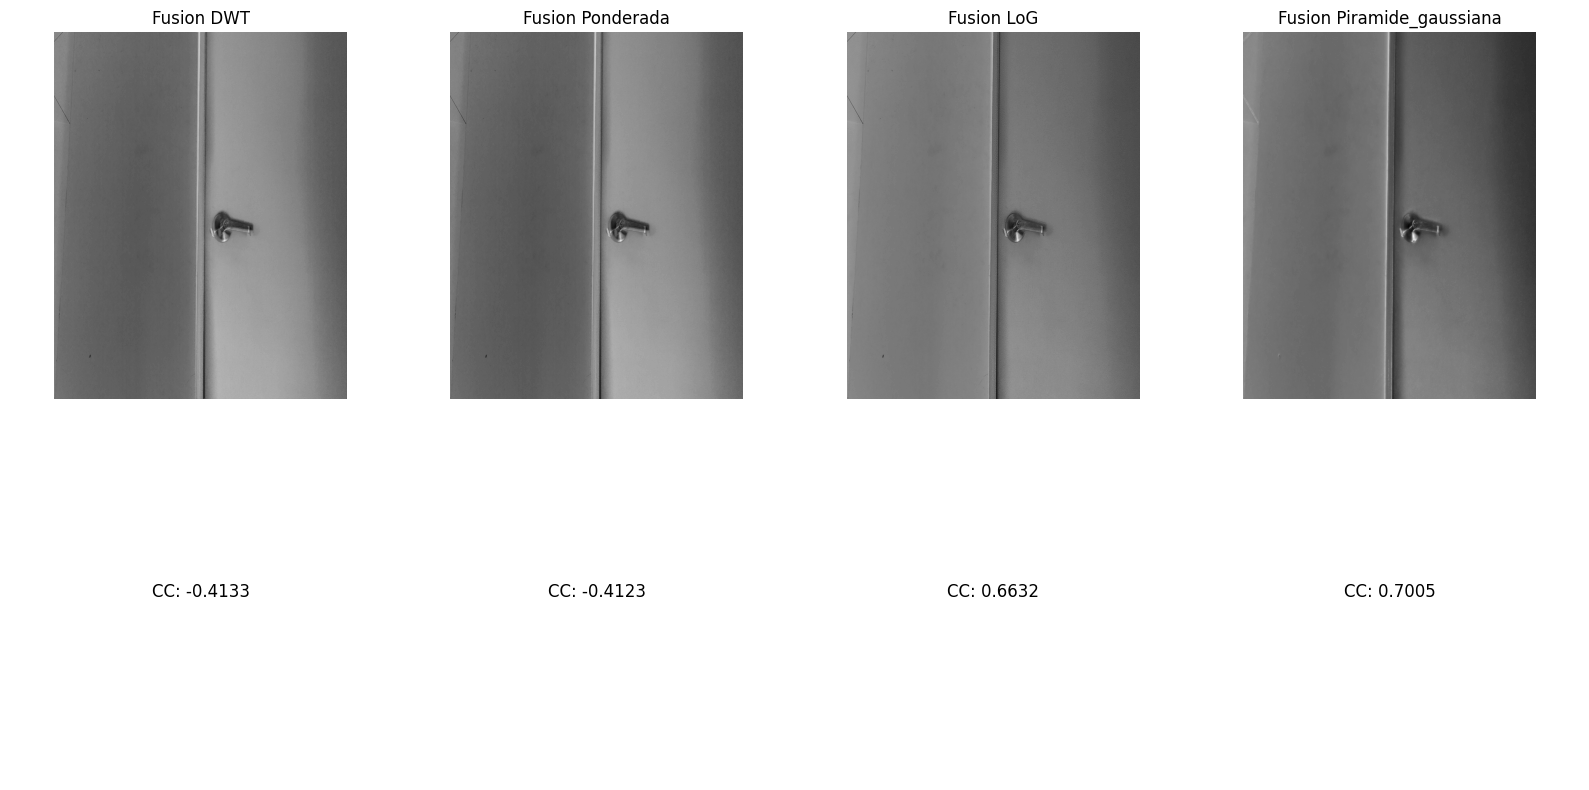

In [4]:

# 3. Coeficiente de Correlación (CC)

import os
import cv2
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Función para cargar y redimensionar imágenes en escala de grises
def load_and_resize_gray_image(path, target_size):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, target_size[::-1])  # Revertir las dimensiones de target_size
    return image_resized

# Función para calcular el Coeficiente de Correlación entre dos imágenes
def calculate_correlation_coefficient(image1, image2):
    return pearsonr(image1.ravel(), image2.ravel())[0]

# Rutas de los directorios de las imágenes fusionadas (modifica según sea necesario)
fusion_directories = ['DWT', 'Ponderada', 'LoG', 'Piramide_gaussiana']

# Nombres de las imágenes fusionadas
fusion_image_names = ['FUSION_DWT.jpg', 'FUSION_Ponderada.jpg', 'FUSION_Log_Color.jpg', 'FUSION_Piramide_gaussiana.jpg']

# Ruta de la imagen RGB (modifica según sea necesario)
image_rgb_path = 'imagen_recortada.jpg'

# Dimensiones objetivo
target_size = (1759, 1406)

# Cargar y redimensionar la imagen RGB en escala de grises
image_rgb_gray = load_and_resize_gray_image(image_rgb_path, target_size)

# Calcular y mostrar el Coeficiente de Correlación para cada imagen fusionada en escala de grises
plt.figure(figsize=(16, 8))

for i, (method, directory_name) in enumerate(zip(fusion_directories, fusion_image_names), 1):
    # Cargar y redimensionar la imagen fusionada en escala de grises
    image_fusionada_gray = load_and_resize_gray_image(os.path.join(method, directory_name), target_size)
    
    # Calcular el Coeficiente de Correlación entre la imagen fusionada y la imagen RGB en escala de grises
    correlation_coefficient = calculate_correlation_coefficient(image_fusionada_gray, image_rgb_gray)

    # Mostrar la imagen fusionada y el valor del Coeficiente de Correlación
    plt.subplot(2, 4, i)
    plt.imshow(image_fusionada_gray, cmap='gray')
    plt.title(f'Fusion {method}')
    plt.axis('off')

    plt.subplot(2, 4, i + len(fusion_directories))
    plt.text(0.5, 0.5, f'CC: {correlation_coefficient:.4f}', fontsize=12, ha='center')
    plt.axis('off')

plt.tight_layout()
plt.show()






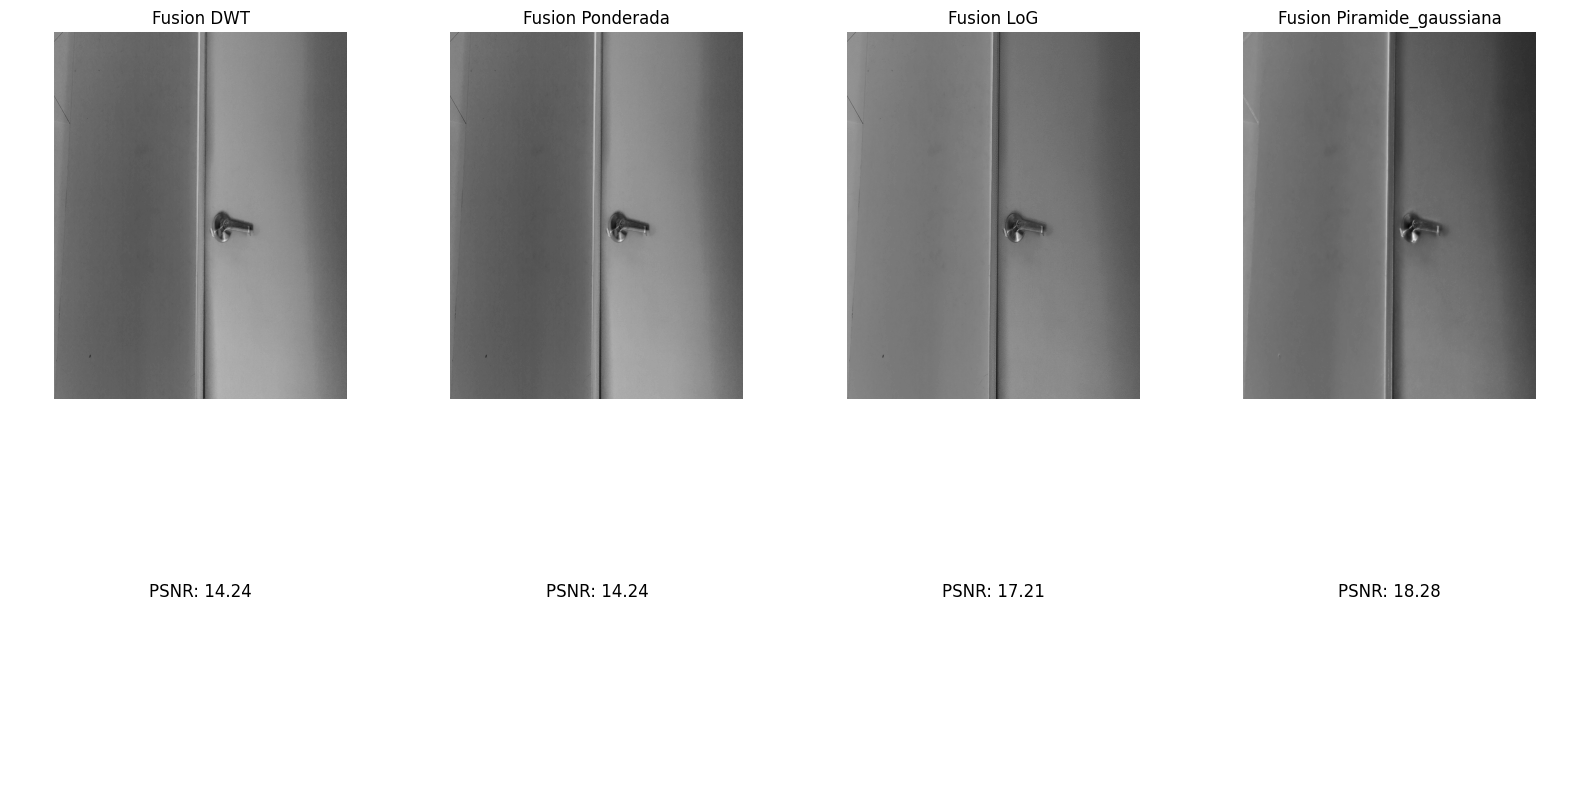

In [3]:

#4. Relación Señal-Ruido Pico (PSNR):

import os
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

# Función para cargar y redimensionar imágenes
def load_and_resize_image_from_directory(directory_path, image_name, target_size):
    image_path = os.path.join(directory_path, image_name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, target_size[::-1])  # Revertir las dimensiones de target_size
    return image_resized

# Rutas de los directorios de las imágenes fusionadas (modifica según sea necesario)
fusion_directories = ['DWT', 'Ponderada', 'LoG', 'Piramide_gaussiana']

# Nombres de las imágenes fusionadas
fusion_image_names = ['FUSION_DWT.jpg', 'FUSION_Ponderada.jpg', 'FUSION_Log_Color.jpg', 'FUSION_Piramide_gaussiana.jpg']

# Ruta de la imagen RGB (modifica según sea necesario)
image_rgb_path = 'imagen_recortada.jpg'

# Dimensiones objetivo
target_size = (1759, 1406)

# Cargar y redimensionar la imagen RGB
image_rgb = load_and_resize_image_from_directory('', image_rgb_path, target_size)

# Calcular y mostrar el PSNR para cada imagen fusionada
plt.figure(figsize=(16, 8))

for i, (method, directory_name) in enumerate(zip(fusion_directories, fusion_image_names), 1):
    # Cargar y redimensionar la imagen fusionada
    image_fusionada = load_and_resize_image_from_directory(method, directory_name, target_size)
    
    # Calcular el PSNR entre la imagen fusionada y la imagen RGB
    psnr_value = psnr(image_fusionada, image_rgb)

    # Mostrar la imagen fusionada y el valor de PSNR
    plt.subplot(2, 4, i)
    plt.imshow(image_fusionada, cmap='gray')
    plt.title(f'Fusion {method}')
    plt.axis('off')

    plt.subplot(2, 4, i + len(fusion_directories))
    plt.text(0.5, 0.5, f'PSNR: {psnr_value:.2f}', ha='center', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()



